In [5]:

multi_path = multi_path = "/home/fb198/BA/DataNephroTexts/classification_data/filtered_multi_labeled_final.json"
data = datasets.Dataset.from_json(multi_path)
data

index2labelname = {7:'colon',
                   1:'prostate',
                   2:'stomach',
                   3:'inflammation',
                   4:'carcinoma',
                   5:'adenoma',
                   6:'BPH'}
labelname2index = {'colon': 7,
                     'prostate': 1,
                     'stomach': 2,
                     'inflammation': 3,
                     'carcinoma': 4,
                     'adenoma': 5,
                     'BPH': 6}
index2labelnamelist = ['colon', 'prostate', 'stomach', 'inflammation', 'carcinoma', 'adenoma', 'BPH']


df_mulitlabel = pd.DataFrame(data)
labels_list = df_mulitlabel.label.tolist()
#labels_list[:2]
for idx, l in enumerate(labels_list):
    temp = []
    for idx_, i in enumerate(l):
        if(i == 1):
            temp.append(index2labelnamelist[idx_])
    labels_list[idx] = temp
df_mulitlabel['labels_test'] = labels_list
df_mulitlabel.columns = ["text", "label_numerical", "label"]
print(f"first five rows in dataframe \n {df_mulitlabel.head(5)}")



x_train, x_test, y_train, y_test = split_train_test(df_mulitlabel['text'].tolist(), df_mulitlabel['label'].tolist())
x_tr, x_val, y_tr, y_val = split_train_test(x_train, y_train)
print(f"number of samples in training data {len(x_train)}, number of samples in testing data {len(x_test)}")

## binarize labels
binarizer = _binarize(df_mulitlabel['label'].tolist())


Using custom data configuration default-1be2fdcf59742fff
Reusing dataset json (/home/fb198/.cache/huggingface/datasets/json/default-1be2fdcf59742fff/0.0.0)


first five rows in dataframe 
                                                 text        label_numerical  \
0   Fragmentiert vorliegende 0,5 cm große Probeen...  [0, 0, 1, 1, 0, 0, 0]   
1   1 (rechts Basis medial): Eine maximal 1,3 cm ...  [0, 1, 0, 0, 1, 0, 0]   
2  Nachbericht:  Im nachträglich eingebetteten Fe...  [0, 0, 0, 0, 1, 0, 0]   
3   jeweils 0,5 cm durchmessende Proben vom Darm ...  [1, 0, 0, 1, 0, 0, 0]   
4   1. Lymphknoten Milzhilus: Ein 1,6 x 1,3 x 0,5...  [1, 0, 1, 0, 0, 0, 0]   

                     label  
0  [stomach, inflammation]  
1    [prostate, carcinoma]  
2              [carcinoma]  
3    [colon, inflammation]  
4         [colon, stomach]  
number of samples in training data 3813, number of samples in testing data 424


In [4]:
class MultiLDataset(Dataset):

    def __init__(self,
                 texts: list,
                 labels: list,
                 tokenizer,
                 max_len: int,
                 binarizer):
        self.binarizer = binarizer
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels : np.ndarray =  self.binarizer.transform(labels)#np.asarray(labels)# 
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item_idx):
        text: str = self.texts[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()

        return {'input_ids': input_ids,
                'attention_mask': attn_mask,
                'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
                }


class DataModule(pl.LightningDataModule):

    ## binarizer is automatically set to None
    ## but it must be initialized with a
    ## binarizer, such as
    def __init__(self, x_tr_:list, y_tr_:list,\
                 x_val_:list, y_val_:list,\
                 x_test_:list, y_test_:list,
                 tokenizer_, batch_size=16, max_token_len=200,
                 binarizer=None):

        super().__init__()
        self.binarizer = binarizer
        self.tr_text = x_tr_
        self.tr_label = y_tr_
        self.val_text = x_val_
        self.val_label = y_val_
        self.test_text = x_test_
        self.test_label = y_test_
        self.tokenizer = tokenizer_
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = MultiLDataset(texts=self.tr_text,
                                       labels=self.tr_label,
                                       tokenizer=self.tokenizer, max_len=self.max_token_len, binarizer=self.binarizer)
        self.val_dataset = MultiLDataset(texts=self.val_text, labels=self.val_label, tokenizer=self.tokenizer,
                                     max_len=self.max_token_len, binarizer=self.binarizer)
        self.test_dataset = MultiLDataset(texts=self.test_text, labels=self.test_label, tokenizer=self.tokenizer,
                                      max_len=self.max_token_len, binarizer=self.binarizer)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=16)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=16)


# we will use the BERT base model(the smaller one)
class LabelsClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self,  n_classes:int=7, steps_per_epoch=None, n_epochs=3, lr=2e-5): #bert_model,
        super(LabelsClassifier,self).__init__()
        

        self.bert = BertModel.from_pretrained(hyperparams_test.bert_model, return_dict=True)
        #self.bert = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=n_classes,return_dict=True)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attn_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attn_mask)
        output = self.classifier(output.pooler_output)

        return output

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)

        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

        return [optimizer], [scheduler]

### move to antoher folder

def _binarize(labels):

    #print(MultiLabelBinarizer().fit(labels).classes_.shape)
    return MultiLabelBinarizer().fit(labels)

def split_train_test(texts:list, labels:list, random_seed=99):

    x_train, x_test, y_train, y_test = \
            train_test_split(texts, labels,\
                            test_size = 0.1, random_state=random_seed,\
                             shuffle=True)
    return x_train, x_test, y_train, y_test

def func_utf8(text):
    try:
        return text.encode("latin-1").decode("UTF-8")
    except Exception as E:
        return  text


def remwithre(text, there=re.compile(re.escape('Mit freundlich')+'.*')):
    return there.sub('', text)

def modelCheckpoint(filename = None, top_models = 10, mode='min'):
    #pytorch_lightning.callbacks.ModelCheckpoint(...)
    if(type(filename) == type(None)):
        filename = 'Labels-{epoch:02d}-{val_loss:.2f}-{train_loss:.2f}'
    return ModelCheckpoint(monitor = 'val_loss' ,# monitored quantity,
                           filename=filename,
                           save_top_k=top_models ,# save the top k models
                           mode=mode,) # mode of the monitored quantity for optimization)

In [56]:
import pandas as pd
import numpy as np
import json
import os
import re
import datasets
from pytorch_lightning.loggers import WandbLogger 
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import List
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, PreTrainedTokenizerFast
from torch import nn ,cuda
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertTokenizerFast
from sklearn.metrics import multilabel_confusion_matrix
# cuda
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## steps to load pl.lightningmodule

## create argparse containing number of labels and bert_model_path of the pretrained
## adjust the class to reading these two info from the args
## call it by loading it from checkpoint
###               LabelsClassifier.load_from_checkpoint

In [7]:
from argparse import Namespace

args = {
    'num_classes': 7,
    'bert_model': "bert-base-german-cased",
}

hyperparams_test = Namespace(**args)
#LabelsClassifier.load_from_checkpoint(
#                        check_point_wp_v1000)
hyperparams_test.bert_model

'bert-base-german-cased'

In [10]:
filter_v1000 = "/home/fb198/BA/classification/multi_class/lightning_logs/version_8_filtered_sp_v1000/checkpoints/Labels-epoch=08-val_loss=0.27-train_loss=0.24.ckpt"
#pretrained_model_pth = "/home/fb198/BA/nlp-in-diagnostic-texts-from-nephropathology-master/LanguageModelling/LanguageModelling/filtered_data_training_bert/sentencepiece_v1000_filtered_training_data"
wp_classification_v1000 = "/home/fb198/BA/classification/multi_class/lightning_logs_wp_v1000_cross_validation/version_5/checkpoints/Kfold_5_model_bert-base-german-cased_ep_-v9.ckpt"
wp_pre_trained_model = "/home/fb198/BA/nlp-in-diagnostic-texts-from-nephropathology-master/LanguageModelling/most_relevant/wp_v1000_PT"
tokenizer = PreTrainedTokenizerFast.from_pretrained(wp_pre_trained_model)
from argparse import Namespace

args = {
    'num_classes': 7,
    'bert_model': "/home/fb198/BA/nlp-in-diagnostic-texts-from-nephropathology-master/LanguageModelling/most_relevant/wp_v1000_PT",
}

hyperparams_test = Namespace(**args)
#LabelsClassifier.load_from_checkpoint(
#                        check_point_wp_v1000)
#hyperparams_test.bert_model
model = LabelsClassifier.load_from_checkpoint(
                        wp_classification_v1000)

Some weights of the model checkpoint at /home/fb198/BA/nlp-in-diagnostic-texts-from-nephropathology-master/LanguageModelling/most_relevant/wp_v1000_PT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/fb198/BA

In [14]:
def predict(description, opt_thresh):
    text_enc = tokenizer.encode_plus(
            description,
            None,
            add_special_tokens=True,
            max_length= 512,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    model.to('cpu')
    outputs = model(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    
    preds = [(pred > opt_thresh) for pred in pred_out ]

    preds = np.asarray(preds)

    new_preds = preds.reshape(1,-1).astype(int)

    pred_tags = new_preds
    return pred_tags 

In [135]:
opt_thresh_ = 0.4100000000000002
clinical_texts = df_mulitlabel.text.tolist()
trues_, preds = [], []
tags_list = []
for i in range(500):#,500,1000,1520]:
    tags = predict(clinical_texts[i],opt_thresh_)
    #print("========== Test Result ==========")
    #print("description: \n")
    #print(clinical_texts[i][:500], "\n==========   ==========   ==========")
    #print("real label: ", df_mulitlabel.iloc[i].label)
    #print("==========   ==========   ==========")
    #print("predicted labels: ")
    #print(binarizer.inverse_transform(tags))
    tags_list.append(tags[0])
    trues_.append(df_mulitlabel.iloc[i].label)
    preds.append(list(binarizer.inverse_transform(tags)[0]))
tags_list = np.asarray(tags_list)
    

In [36]:
labelname2index = {'colon': 7,
                     'prostate': 1,
                     'stomach': 2,
                     'inflammation': 3,
                     'carcinoma': 4,
                     'adenoma': 5,
                     'BPH': 6}

In [119]:
cp_trues = trues_binarized.copy()
cp_tags = tags_list.copy()


In [136]:
trues_binarized = binarizer.transform(trues_)
trues_binarized
#.ravel()
binarized2idx = {
                 6:2, ## stomach
                 4:3, ## inflammation
                 1:5, ## adenoma
                 5:1, ## prostate
                 2:4, ##carcinoma
                 3:7, ##colon
                 0:6 ##BPH
}
#index2labelnamelist = ['colon', 'prostate', 'stomach', 'inflammation', 'carcinoma', 'adenoma', 'BPH']
def convert(matrix):
    for idx_loc , vec_true in enumerate(matrix):
        converted = [binarized2idx[idx_] if val == 1 else val for idx_,val  in enumerate(vec_true)]
        matrix[idx_loc] = converted
    return matrix 
converted_trues_binarized = convert(trues_binarized.copy())
converted_tag = convert(tags_list.copy())

In [121]:
confusion_matrix(converted_trues_binarized.ravel(), converted_tag.ravel())

array([[1628,    2,    1,    2,   11,    0,    0,    4],
       [   0,   85,    0,    0,    0,    0,    0,    0],
       [   4,    0,   89,    0,    0,    0,    0,    0],
       [  24,    0,    0,   40,    0,    0,    0,    0],
       [  34,    0,    0,    0,   54,    0,    0,    0],
       [   7,    0,    0,    0,    0,   13,    0,    0],
       [   7,    0,    0,    0,    0,    0,    0,    0],
       [   9,    0,    0,    0,    0,    0,    0,   86]])

In [124]:
converted_tag

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [89]:
converted_trues_binarized

array([[0, 0, 0, 0, 3, 0, 2],
       [0, 5, 0, 0, 0, 0, 2],
       [0, 5, 0, 0, 0, 1, 0],
       [0, 0, 4, 0, 0, 0, 2],
       [0, 0, 4, 7, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 2],
       [6, 0, 0, 7, 0, 0, 0],
       [0, 0, 4, 0, 0, 1, 0],
       [0, 0, 0, 7, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 4, 0, 0, 1, 0],
       [0, 0, 4, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 4, 7, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 3, 0, 2],
       [0, 0, 0, 7, 0, 0, 0]])

In [100]:
##### from collections import Counter
Counter(converted_trues_binarized.ravel()).most_common()  

[(0, 2752), (1, 167), (7, 162), (4, 151), (2, 124), (3, 93), (5, 36), (6, 15)]

((500, 7), (500, 7))

In [101]:
Counter(converted_tag.ravel()).most_common()

[(0, 2837), (1, 169), (7, 154), (4, 124), (2, 122), (3, 66), (5, 28)]

In [97]:
multilabel_confusion_matrix(converted_trues_binarized.ravel(), converted_tag.ravel())

array([[[ 627,  121],
        [  36, 2716]],

       [[3331,    2],
        [   0,  167]],

       [[3373,    3],
        [   5,  119]],

       [[3403,    4],
        [  31,   62]],

       [[3330,   19],
        [  46,  105]],

       [[3464,    0],
        [   8,   28]],

       [[3485,    0],
        [  15,    0]],

       [[3330,    8],
        [  16,  146]]])

In [129]:
trues_binarized[0]

array([0, 0, 0, 0, 1, 0, 1])

In [244]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [254]:
average_precision_score(trues_binarized[:, i], tags_list[:, i])

0.03

In [255]:
fpr = dict()
tpr = dict()
n_classes = trues_binarized.shape[1]

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trues_binarized[:, i], tags_list[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(trues_binarized.ravel(), tags_list.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [256]:
binarizer.classes_

array(['BPH', 'adenoma', 'carcinoma', 'colon', 'inflammation', 'prostate',
       'stomach'], dtype=object)

In [257]:
roc_auc

{0: 0.5,
 1: 0.8888888888888888,
 2: 0.8204614888328051,
 3: 0.9387829644239901,
 4: 0.8284193284193284,
 5: 0.9969969969969971,
 6: 0.9758493479752918,
 'micro': 0.9125769493844049}

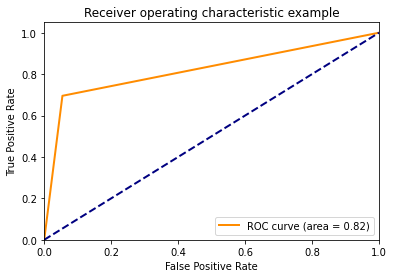

In [258]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

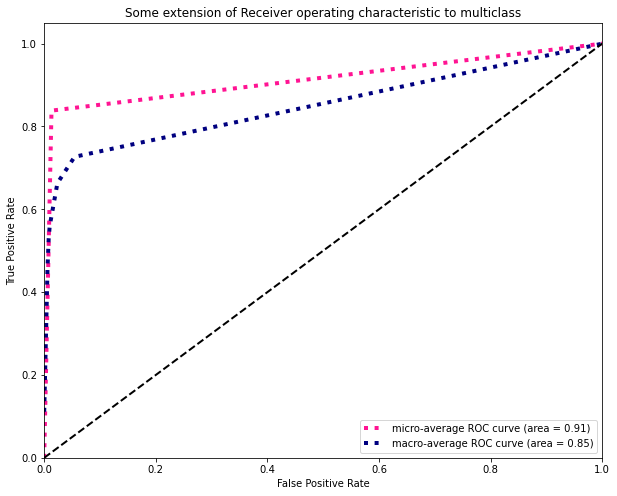

In [259]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

"""
colors = cycle(["aqua", "darkorange", "cornflowerblue", 'green', 'pink',"brown", 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
"""
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


In [145]:


macro_roc_auc_ovo = roc_auc_score(trues_binarized, tags_list, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    trues_binarized, tags_list, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(trues_binarized, tags_list, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    trues_binarized, tags_list, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.849914 (macro),
0.909117 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.849914 (macro),
0.909117 (weighted by prevalence)


In [147]:

micro_roc_auc_ovo = roc_auc_score(trues_binarized, tags_list, multi_class="ovo", average="micro")
weighted_roc_auc_ovo = roc_auc_score(
    trues_binarized, tags_list, multi_class="ovo", average="weighted"
)
micro_roc_auc_ovr = roc_auc_score(trues_binarized, tags_list, multi_class="ovr", average="micro")
weighted_roc_auc_ovr = roc_auc_score(
    trues_binarized, tags_list, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(micro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(micro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.912577 (macro),
0.909117 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.912577 (macro),
0.909117 (weighted by prevalence)


### PR curves

In [148]:
# precision-recall curve and f1 for an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

'adenoma'

In [169]:
converted_trues_binarized.ravel()

array([0, 0, 0, ..., 0, 1, 0])

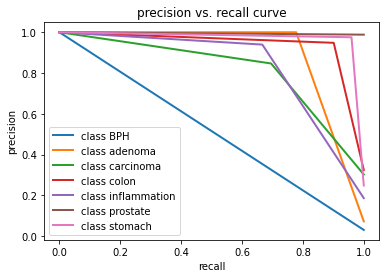

In [177]:
n_calsses = trues_binarized.shape[0]
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(trues_binarized[:, i],
                                                        tags_list[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'class {binarizer.classes_[i]}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

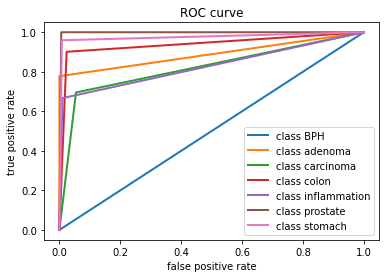

In [178]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trues_binarized[:, i],
                                  tags_list[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'class {binarizer.classes_[i]}')

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

In [179]:
## for model comparision we need the micro averaged curve!

In [193]:
#converted_tag


array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0]])

In [220]:
for i in range(6):
    
    print(precision_score(trues_binarized[:,i], tags_list[:,i], average='micro'))

0.97
0.984
0.87
0.952
0.93
0.996


In [218]:
precision_score(trues_binarized, tags_list, average='micro')
#

0.9457013574660633

In [194]:
print(classification_report(trues_binarized, tags_list)) #, output_dict=True
 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       1.00      0.78      0.88        36
           2       0.85      0.70      0.76       151
           3       0.95      0.90      0.92       162
           4       0.94      0.67      0.78        93
           5       0.99      1.00      0.99       167
           6       0.98      0.96      0.97       124

   micro avg       0.95      0.84      0.89       748
   macro avg       0.81      0.71      0.76       748
weighted avg       0.92      0.84      0.88       748
 samples avg       0.95      0.88      0.89       748



/home/fb198/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fb198/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
average_precision_score(trues_binarized, tags_list, average="micro")

0.8272916840944523

In [ ]:
#Calculate Samples Precision¶
for i in range (len(y_true)):
  p= metrics.precision_score(y_true[i,:], y_pred[i,:])
  totalPrecision+=p
  print("For Sample {} precision: {:.2f} ".format(y_true[i,:], p ))
print("Sample Precision: {:.2f}".format(totalPrecision/len(y_true)))

In [ ]:
#In multi-label classification, the roc_auc_score function is extended by averaging over the labels as above.



In [208]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(trues_binarized[:, i],
                                                        tags_list[:, i])
    average_precision[i] = average_precision_score(trues_binarized[:, i], tags_list[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(trues_binarized.ravel(),
    tags_list.ravel())
average_precision["micro"] = average_precision_score(trues_binarized, tags_list,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.83


In [209]:
precision
average_precision

{0: 0.03,
 1: 0.7937777777777778,
 2: 0.6808164922025208,
 3: 0.8864171877505211,
 4: 0.6882626262626264,
 5: 0.9881656804733728,
 6: 0.9460787942887361,
 'micro': 0.8272916840944523}

In [207]:
average_precision_ = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(trues_binarized[:, i], tags_list[:, i])
    average_precision_[i] =average_precision_score(trues_binarized[:, i], tags_list[:, i])

print ("average_precision {} ".format(average_precision_))

average_precision {0: 0.03, 1: 0.7937777777777778, 2: 0.6808164922025208, 3: 0.8864171877505211, 4: 0.6882626262626264, 5: 0.9881656804733728, 6: 0.9460787942887361} 


In [223]:
trues_binarized

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0]])

In [224]:
# A "micro-average": quantifying score on all classes jointly
pres_dict = dict()
recal_dict = dict()
avg_dict = dict()
pres_dict["micro"], recal_dict["micro"], _ = precision_recall_curve(trues_binarized.ravel(),
    tags_list.ravel())
avg_dict["None"] = average_precision_score(trues_binarized, tags_list, average=None)
avg_dict["Void"] = average_precision_score(trues_binarized, tags_list)
avg_dict["micro"] = average_precision_score(trues_binarized, tags_list, average="micro")
avg_dict["macro"] = average_precision_score(trues_binarized, tags_list, average="macro")
avg_dict["samples"] = average_precision_score(trues_binarized, tags_list, average="samples")
avg_dict["weighted"] = average_precision_score(trues_binarized, tags_list, average="weighted")

#print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
    
avg_dict

ValueError: multiclass format is not supported

{'micro': array([0.21371429, 0.94570136, 1.        ])}

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.83')

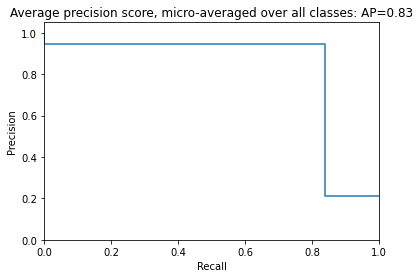

In [213]:
plt.figure()
plt.step(recal_dict['micro'], pres_dict['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(avg_dict["micro"]))

In [215]:
recal_dict['micro']

array([1.        , 0.83823529, 0.        ])

In [222]:
pres_dict['micro']

array([0.21371429, 0.94570136, 1.        ])

In [239]:
from sklearn import metrics
x = metrics.precision_recall_fscore_support(converted_trues_binarized.ravel(),
    converted_tag.ravel(), beta=0.5, average='micro')
x

(0.9551428571428572, 0.9551428571428572, 0.9551428571428573, None)

In [234]:
set((converted_trues_binarized.ravel()))

{0, 1, 2, 3, 4, 5, 6, 7}

In [238]:
x = np.asarray(x)
x[2]

array([0.96312057, 0.99051008, 0.97222222, 0.86834734, 0.8114374 ,
       0.94594595, 0.        , 0.93830334])

In [241]:
br_f1=metrics.f1_score(converted_trues_binarized.ravel(),converted_tag.ravel(), average='micro')
br_hamm=metrics.hamming_loss(converted_trues_binarized.ravel(), converted_tag.ravel())
br_f1, br_hamm


(0.9551428571428572, 0.04485714285714286)